# IOTA microgrid tests

In [1]:
from iota import ProposedTransaction, Address, Tag, TryteString, Iota, Transaction
from iota.crypto.types import Seed
import json
import pandapower as pp
import numpy as np
from numpy.random import rand
import pandas as pd
import os
import pprint
import time
from hashlib import sha256
import time
from bitcoinaddress import Wallet
from tqdm import tqdm

In [2]:
def create_synthetic_data(d_steps, d_num_agents, d_t_gens):
    demand_df = pd.DataFrame(np.random.uniform(low=30, high=35, size=(d_num_agents, d_steps)))
    price_df = pd.DataFrame(np.random.uniform(low=12, high=15, size=(d_num_agents, d_steps)))
    supply_df = pd.DataFrame(np.random.uniform(low=66, high=70, size=(d_num_agents, d_steps)))
    gens = np.random.choice(demand_df.index, size = (d_t_gens,), replace=False)
    for gen in gens:
        price_df.iloc[gen] = np.zeros((1, d_steps))
        supply_df.iloc[gen] = np.zeros((1, d_steps))
    return demand_df, price_df, supply_df

In [3]:
class Block:
    def __init__(self, index, transactions, timestamp, previous_hash, nonce=0):
        self.index = index
        self.transactions = transactions
        self.timestamp = timestamp
        self.previous_hash = previous_hash
        self.nonce = nonce

    def compute_hash(self):
        """
        A function that return the hash of the block contents.
        """
        block_string = json.dumps(self.__dict__, sort_keys=True)
        return sha256(block_string.encode()).hexdigest()


class Blockchain:
    # difficulty of our PoW algorithm
    difficulty = 2

    def __init__(self):
        self.unconfirmed_transactions = []
        self.chain = []

    def create_genesis_block(self):
        """
        A function to generate genesis block and appends it to
        the chain. The block has index 0, previous_hash as 0, and
        a valid hash.
        """
        genesis_block = Block(0, [], 0, "0")
        genesis_block.hash = genesis_block.compute_hash()
        self.chain.append(genesis_block)

    @property
    def last_block(self):
        return self.chain[-1]

    def add_block(self, block, proof):
        """
        A function that adds the block to the chain after verification.
        Verification includes:
        * Checking if the proof is valid.
        * The previous_hash referred in the block and the hash of latest block
          in the chain match.
        """
        previous_hash = self.last_block.hash

        if previous_hash != block.previous_hash:
            return False

        if not Blockchain.is_valid_proof(block, proof):
            return False

        block.hash = proof
        self.chain.append(block)
        return True

    @staticmethod
    def proof_of_work(block):
        """
        Function that tries different values of nonce to get a hash
        that satisfies our difficulty criteria.
        """
        block.nonce = 0

        computed_hash = block.compute_hash()
        while not computed_hash.startswith('0' * Blockchain.difficulty):
            block.nonce += 1
            computed_hash = block.compute_hash()

        return computed_hash

    def add_new_transaction(self, transaction):
        self.unconfirmed_transactions.append(transaction)

    @classmethod
    def is_valid_proof(cls, block, block_hash):
        """
        Check if block_hash is valid hash of block and satisfies
        the difficulty criteria.
        """
        return (block_hash.startswith('0' * Blockchain.difficulty) and
                block_hash == block.compute_hash())

    @classmethod
    def check_chain_validity(cls, chain):
        result = True
        previous_hash = "0"

        for block in chain:
            block_hash = block.hash
            # remove the hash field to recompute the hash again
            # using `compute_hash` method.
            delattr(block, "hash")

            if not cls.is_valid_proof(block, block_hash) or \
                    previous_hash != block.previous_hash:
                result = False
                break

            block.hash, previous_hash = block_hash, block_hash

        return result

    def mine(self):
        """
        This function serves as an interface to add the pending
        transactions to the blockchain by adding them to the block
        and figuring out Proof Of Work.
        """
        if not self.unconfirmed_transactions:
            return False

        last_block = self.last_block

        new_block = Block(index=last_block.index + 1,
                          transactions=self.unconfirmed_transactions,
                          timestamp=time.time(),
                          previous_hash=last_block.hash)

        proof = self.proof_of_work(new_block)
        self.add_block(new_block, proof)

        self.unconfirmed_transactions = []

        return True


class Wrapper:
    def __init__(self):
        self.blockchain = Blockchain()
        self.blockchain.create_genesis_block()
        self.peers = []

    def new_transaction(self, tx_data):
        required_fields = ['author', 'content']
        
        for field in required_fields:
            if not tx_data.get(field):
                return "Invalid transaction data"
        tx_data['timestamp'] = time.time()
        self.blockchain.add_new_transaction(tx_data)
        
        return 'Success'
    
    def get_chain(self):
        chain_data = []
        for block in self.blockchain.chain:
            chain_data.append(block.__dict__)
            return json.dumps({"length": len(chain_data), "chain": chain_data, "peers": list(self.peers)})
    
    def mine_unconfirmed_transactions(self):
        result = self.blockchain.mine()
        if not result:
            return "No transactions to mine"
        else:
            # Making sure we have the longest chain before announcing to the network
            chain_length = len(self.blockchain.chain)
            
            peers = []
            for peer in self.peers:
                new_peer = {'address': peer['address'], 'chain': self.blockchain.chain}
                peers.append(new_peer)
            self.peers = peers
                
            self.consensus()
            
            return "Block #{} is mined.".format(self.blockchain.last_block.index)

    def register_new_peers(self, node_address):
        if not node_address:
            return "Invalid data"
        
        peer = {'address': node_address, 'chain': None}

   
     # Add the node to the peer list
        self.peers.append(peer)

        # Return the consensus blockchain to the newly registered node
        # so that he can sync
        return self.get_chain()
        
    def create_chain_from_dump(self, chain_dump):
        generated_blockchain = Blockchain()
        generated_blockchain.create_genesis_block()
        for idx, block_data in enumerate(chain_dump):
            if idx == 0:
                continue  # skip genesis block
            block = Block(block_data["index"],
                          block_data["transactions"],
                          block_data["timestamp"],
                          block_data["previous_hash"],
                          block_data["nonce"])
            proof = block_data['hash']
            added = generated_blockchain.add_block(block, proof)
            if not added:
                raise Exception("The chain dump is tampered!!")
        return generated_blockchain

    def verify_and_add_block(self, block_data):
        block = Block(block_data["index"],
                      block_data["transactions"],
                      block_data["timestamp"],
                      block_data["previous_hash"],
                      block_data["nonce"])

        proof = block_data['hash']
        added = self.blockchain.add_block(block, proof)

        if not added:
            return "The block was discarded by the node", 400

        return "Block added to the chain", 201


    def create_chain_from_dump(self, chain_dump):
        generated_blockchain = Blockchain()
        generated_blockchain.create_genesis_block()
        for idx, block_data in enumerate(chain_dump):
            if idx == 0:
                continue  # skip genesis block
            block = Block(block_data["index"],
                          block_data["transactions"],
                          block_data["timestamp"],
                          block_data["previous_hash"],
                          block_data["nonce"])
            proof = block_data['hash']
            added = generated_blockchain.add_block(block, proof)
            if not added:
                raise Exception("The chain dump is tampered!!")
        return generated_blockchain

    def get_pending_tx(self):
        return json.dumps(self.blockchain.unconfirmed_transactions)


    def consensus(self):
        """
        Our naive consnsus algorithm. If a longer valid chain is
        found, our chain is replaced with it.
        """
        longest_chain = None
        current_len = len(self.blockchain.chain)

        for node in self.peers:
            length = len(node['chain'])
            chain = node['chain']
            if length > current_len and self.blockchain.check_chain_validity(chain):
                current_len = length
                longest_chain = chain

        if longest_chain:
            blockchain = longest_chain
            return True

        return False
    
class Agent:
    def __init__(self, demand, supply, node, address, price, wrapper):
        self.demand = demand
        self.supply = supply
        self.node = node
        self.address = address
        self.price = price
        self.register_peer(wrapper)

    def register_peer(self, wrapper):
        wrapper.register_new_peers(self.address)
    
    def publish_energy_info(self, step):
        agents_info = {}
        agents_info['node'] = self.node
        agents_info['demand'] = self.demand[step]
        agents_info['supply'] = self.supply[step]
        agents_info['consumption'] = self.demand[step] - self.supply[step]
        agents_info['price'] = self.price[step]
        
        return self.node, agents_info
            
    def get_demand(self):
        return self.demand
    
    def get_supply(self):
        return self.supply
    
    def get_node(self):
        return self.node
    
    def get_address(self):
        return self.address
    
    def get_consumption(self):
        return self.consumption
    
    def get_prices(self):
        return self.price
    
    def set_payment_data(self, data):
        self.payment_data = data

    def pay_power(self, step, wrapper):
        """ Send power payment
        
        Args:
            step (float): step running at the moment.
        """
        unpack_data = self.payment_data
        for index, node in enumerate(unpack_data['node']):
            tx_data = {'author': self.address, 
                       'content': {'payment': unpack_data['price']*unpack_data['power'][index], 
                                   'seller': unpack_data['seller']}}
            wrapper.new_transaction(tx_data)

In [4]:
def single_sided_auction(node_data, supply, demand, price, agents):
    node_vec = []
    supply_vec = []
    supply_price = []
    demand = []
    ED = 0
    for node in node_data:
        node_vec.append(node['node'])
        supply_vec.append(node['supply'])
        supply_price.append(node['price'])
        demand.append(node['demand'])
        ED += node['demand']
    supply_df = pd.DataFrame(data = {'Agents': node_vec, 'Supply': supply_vec, 'Price': supply_price, 'Demand': demand})
    supply_df = supply_df.sort_values(by='Price')
    cum_supply = np.cumsum(supply_df['Supply'])
    supply_df['Cumsum'] = cum_supply
    for index, value in enumerate(supply_df.Cumsum):
        if value >= ED:
            break
    return supply_df, ED, supply_df.iloc[index]['Price']

In [5]:
def micro_grid_exec(step, supply, demand, price, agents):
    net = pp.create_empty_network()
    min_pu = 0.95
    max_pu = 1.05

    bus = []
    for index in range(len(agents)):
        bus.append(pp.create_bus(net, vn_kv=110, min_vm_pu=min_pu, max_vm_pu=max_pu))

    lines = []
    for index in range(len(agents)):
        if index < len(agents) - 1:
            lines.append(pp.create_line(net, bus[index], bus[index+1], length_km=1, std_type='149-AL1/24-ST1A 110.0'))
        else:
            lines.append(pp.create_line(net, bus[index], bus[0], length_km=1, std_type='149-AL1/24-ST1A 110.0'))

    for index in range(len(agents)):
        pp.create_load(net, bus[index], p_mw=supply_df['Demand'][index])
        
    gens = []
    for index in range(len(agents)):
        if supply.iloc[index][step] != 0:
            pp.create_gen(net, bus[index], p_mw=0, min_p_mw=0, max_p_mw=np.array(supply[step])[index], controllable=True, slack=True)
            
    pp.runpp(net)
    pf_result = net.res_gen
    
    return pf_result

In [6]:
def payment_setup(step, auction_price, wrapper, supply, demand, price, agents):
    
    power_per_agent = []
    for agent in agents:
        agent.get_node()
        demand = agent.get_demand()[step]
        try:
            supply = gen_dict[agent.get_node()]
        except:
            supply = agent.get_supply()[step]
        to_app = supply - demand
        if abs(to_app) < 0.00001:
            to_app = 0
        power_per_agent.append(to_app)
        
    to_earn = {}
    to_pay = {}
    for index, payment in enumerate(power_per_agent):
        if payment < 0:
            to_pay[index] = abs(payment)
        else:
            to_earn[index] = payment
    
    payment_info = {}
    for payer, balance in to_pay.items():
        payment_info[payer] = {'node': [], 'total': []}
        for earner, gain in to_earn.items():
            if gain > 0:
                if balance >= gain:
                    payment_info[payer]['node'].append(earner)
                    payment_info[payer]['total'].append(gain)
                    to_pay[payer] = to_pay[payer] - gain
                    to_earn[earner] = to_earn[earner] - gain
                elif balance < gain:
                    payment_info[payer]['node'].append(earner)
                    payment_info[payer]['total'].append(balance)
                    to_pay[payer] = to_pay[payer] - balance
                    to_earn[earner] = to_earn[earner] - balance
                    break
        
    gather_data = {}
    for index, agent in enumerate(agents):
        info_dict = {}
        info_dict['price'] = auction_price
        try:
            info_dict['node'] = payment_info[index]['node']
            info_dict['power'] = payment_info[index]['total']
            info_dict['seller'] = agents[payment_info[index]['node'][0]].get_address()
        except:
            pass
        gather_data[index] = info_dict
    for index, agent in enumerate(agents):
        data = gather_data[index]
        agent.set_payment_data(data)
        
    pay_nodes = set(nodes) - set(gen_nodes)
    for node in pay_nodes:
        agents[node].pay_power(step, wrapper)

In [21]:
d_steps_vec = [2,4,8]
d_agents_vec = [500000, 1000000, 5000000]
results_df = pd.DataFrame(columns = ['steps', 'agents', 'dlt', 'mean', 'max', 'min'])
for d_steps in tqdm(d_steps_vec):
    for d_num_agents in d_agents_vec:
        d_t_gens = int(0.3 * d_num_agents)

        demand, price, supply = create_synthetic_data(d_steps, d_num_agents, d_t_gens)
        steps_vec = np.linspace(0, d_steps, d_steps + 1)
        
        times_vec = []
        num_agents = demand.shape[0]
        steps = demand.shape[1]

        a_series = (supply != 0).any(axis=1)
        new_df = supply.loc[a_series]
        gen_nodes = np.array(new_df.index)

        addresses = []
        for i in range(0, num_agents):
            wallet = Wallet()
            addresses.append(wallet.key.__dict__['mainnet'].__dict__['wif'])
        wrapper = Wrapper()
        agents = []
        for index in range(0, num_agents):
            agents.append(Agent(np.array(demand.iloc[index]), 
                               np.array(supply.iloc[index]), 
                               index, addresses[index],
                               np.array(price.iloc[index]), wrapper))
        nodes = list(np.linspace(0,num_agents-1, num_agents, dtype=np.int))
        steps_vec = list(np.linspace(0,steps-1, steps, dtype=np.int))
        times_vec = []
        for step in steps_vec:
            start = time.time()
            step_energy_info = []
            for index, agent in enumerate(agents):
                node, info_dict = agent.publish_energy_info(step)
                step_energy_info.append(info_dict)
            supply_df, ED, auction_price = single_sided_auction(step_energy_info,supply, demand, price, agents)
            pf_result = micro_grid_exec(step, supply, demand, price, agents)
            supply_df.set_index('Agents', inplace=True)
            gen_values = pf_result['p_mw']
            gen_dict = dict(zip(gen_nodes, gen_values))
            total_demand = sum(supply_df['Demand'])
            total_supply = sum(gen_dict.values())
            losses = total_supply - total_demand
            payment_setup(step, auction_price, wrapper, supply, demand, price, agents)
            wrapper.mine_unconfirmed_transactions()
            times_vec.append(time.time()-start)
        new_df = pd.DataFrame(data={'steps': [d_steps], 
                                     'agents': [d_num_agents], 
                                     'dlt': ['blockchain'], 
                                     'mean': [np.mean(times_vec)], 
                                     'max': [np.max(times_vec)],
                                     'min': [np.min(times_vec)]})
        results_df = results_df.append(new_df, ignore_index = True)

  0%|          | 0/3 [106:14:32<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
results_df

In [30]:
results_df = pd.read_csv('./time_res_block_age.csv')
results_df = results_df.append(pd.read_csv('./time_res_block_age1.csv'), ignore_index = True)
results_df = results_df.drop(['Unnamed: 0'], axis = 1)
results_df

,steps,agents,dlt,mean,max,min
0,2,1000,blockchain,12.315038,13.545226,11.084850
1,2,2000,blockchain,23.229732,23.282717,23.176746
2,2,3000,blockchain,35.582368,37.319252,33.845484
3,4,1000,blockchain,10.896247,11.019669,10.734501
4,4,2000,blockchain,22.367676,22.879491,21.865167
5,4,3000,blockchain,34.131632,35.778204,33.312657
6,8,1000,blockchain,11.094972,12.670023,10.735306
7,8,2000,blockchain,22.384557,23.177749,21.717816
8,8,3000,blockchain,34.585405,35.575285,33.223957
9,2,5000,blockchain,58.891386,59.140970,58.641801


<AxesSubplot:xlabel='agents'>

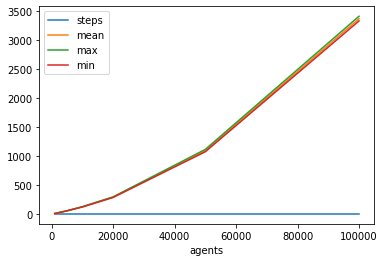

In [31]:
results_df.groupby(['agents']).mean().plot()

In [11]:
iota_df = pd.read_csv('./time_res_iota.csv')
iota_df.append(pd.read_csv('./time_res_iota1.csv'))
iota_df.drop(['Unnamed: 0'], axis = 1)
iota_df.to_csv('./time_res_iota.csv')

<AxesSubplot:xlabel='agents'>

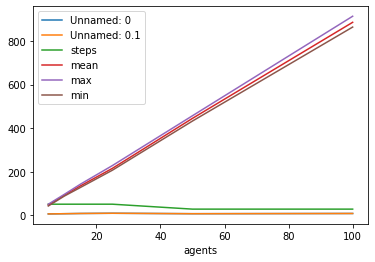

In [12]:
iota_df.groupby(['agents']).mean().plot()

In [13]:
iota_df = pd.read_csv('./time_res_iota_sec.csv')
iota_df = iota_df.append(pd.read_csv('./time_res_iota_sec1.csv'), ignore_index = True)
iota_df = iota_df.drop(['Unnamed: 0'], axis = 1)

In [14]:
iota_df

,steps,agents,dlt,mean,max,min
0,8,5,blockchain,27.973812,30.784005,25.961086
1,8,10,blockchain,56.666952,60.225506,52.858338
2,8,15,blockchain,84.005368,88.498308,80.594514
3,8,25,blockchain,138.303078,146.708361,125.301514
4,8,50,blockchain,277.289704,287.560044,254.018463
5,8,100,blockchain,568.506106,600.676966,530.184103
6,48,5,blockchain,24.585534,28.067017,23.497502
7,48,10,blockchain,57.835862,64.257864,50.662923
8,48,15,blockchain,87.779259,93.676526,74.014945
9,48,25,blockchain,137.276756,146.238740,126.273663


<AxesSubplot:xlabel='agents'>

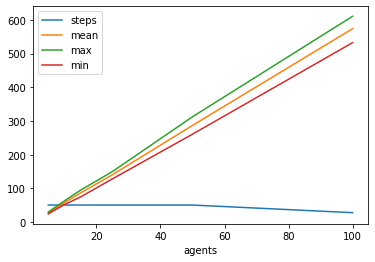

In [15]:
iota_df.groupby(['agents']).mean().plot()

In [16]:
iota_df

,steps,agents,dlt,mean,max,min
0,8,5,blockchain,27.973812,30.784005,25.961086
1,8,10,blockchain,56.666952,60.225506,52.858338
2,8,15,blockchain,84.005368,88.498308,80.594514
3,8,25,blockchain,138.303078,146.708361,125.301514
4,8,50,blockchain,277.289704,287.560044,254.018463
5,8,100,blockchain,568.506106,600.676966,530.184103
6,48,5,blockchain,24.585534,28.067017,23.497502
7,48,10,blockchain,57.835862,64.257864,50.662923
8,48,15,blockchain,87.779259,93.676526,74.014945
9,48,25,blockchain,137.276756,146.238740,126.273663
